In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def sample_deceleration(shape = 2., scale = 1.3):
    max_dec = 14
    dec = np.random.gamma(shape, scale)
    dec = max_dec if dec > max_dec else dec
    return dec

In [3]:
def sample_weight(min_weight=5000.0, max_weight=7000.0):
    return min([max_weight, min_weight+((0.8*max_weight-min_weight)/3)*np.random.gamma(3.5, 0.9)])

In [4]:
min_dec = 0.001
max_dec = 14.0
min_time = 1.0
max_time = 120.0
m = (max_time-min_time)/(np.sqrt(min_dec)-np.sqrt(max_dec))
b = max_time - m*np.sqrt(min_dec)
print(m)
print(b)


-32.07517247244085
121.01430601355648


In [5]:
def get_braking_time(deceleration, min_time=1.0, max_time=120):
    time = m*np.sqrt(deceleration)+b
    time = min_time if time < min_time else time
    time = np.random.normal(time, time/6)
    time = max_time if time > max_time else time
    time = min_time if time < min_time else time
    return time

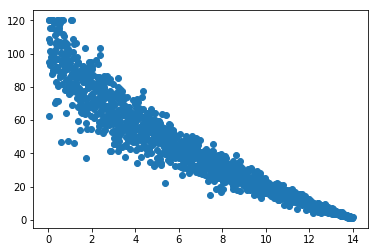

In [6]:
dec_range = np.arange(0.01, 14, 0.01)
time_ranges = [get_braking_time(i) for i in dec_range]
plt.scatter(dec_range,time_ranges)

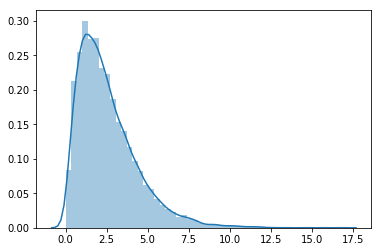

In [7]:
dec = np.random.gamma(2., 1.3, 10000)
sns.distplot(dec)

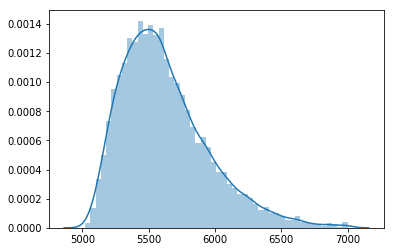

In [8]:
sns.distplot([sample_weight() for i in range(10000)])

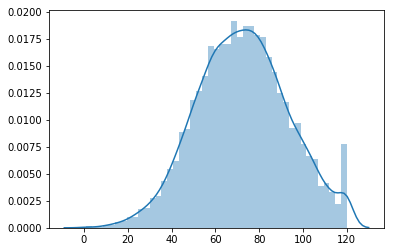

In [9]:
sns.distplot([get_braking_time(dec[i]) for i in range(10000)])

In [10]:
model_weights = [2.41797237e-04,  1.64064786e-04, -2.57633089e-07]

def brake_life(current, dec_window, time_window, weight_window):
    linear_contributions = np.array([1/i for i in range(1,21)])/(sum([1/i for i in range(1,21)]))
    decs = np.dot(linear_contributions, np.array(dec_window).T)
    times = np.dot(linear_contributions, np.array(time_window).T)
    weights = np.dot(linear_contributions, np.array(weight_window).T)
    life_expectancy = current - (model_weights[0]*decs**2+model_weights[1]*times**0.5+model_weights[2]*weights)
    life_expectancy = max(life_expectancy, 0.0)
    life_expectancy = np.random.normal(life_expectancy, 0.1)
    life_expectancy = max(life_expectancy, 0.0)
    life_expectancy = min(life_expectancy, 100.0)
    return life_expectancy

In [11]:
dec_events = [sample_deceleration() for i in range(20)]
dec_events_window = dec_events
init_brake_life_expectancy = 100.0
brake_life_expectancies = [init_brake_life_expectancy]
time_events = [get_braking_time(dec_event) for dec_event in dec_events]
time_events_window = time_events
weigth_period = np.random.randint(low=80, high=500)
weigth_events = (sample_weight()*np.ones(20)).tolist()
weigth_events_window = weigth_events

dec_contribs = []
time_contribs = []
weight_contribs = []

# Guessing a brake event takes place every 10 seconds
# In order to go from 100% to 0% life expectancy we'll
# use the time span of a month and we are supposing 2000
# brake event per day.
for i in range(60000):
    dec_events.append(sample_deceleration())
    dec_events_window = dec_events[-20:]
    time_events.append(get_braking_time(dec_events[-1]))
    time_events_window = time_events[-20:]
    if weigth_period > 0:
        weigth_period -= 1
        weigth_events.append(weigth_events[-1])
        weigth_events_window = weigth_events[-20:]
    else:
        weigth_period = np.random.randint(low=80, high=500)
        weigth_events.append(sample_weight())
        weigth_events_window = weigth_events[-20:]
    brake_life_expectancies.append(brake_life(brake_life_expectancies[-1], dec_events_window, time_events_window, weigth_events_window))
    

In [12]:
import pandas as pd

In [13]:
brake_data = pd.DataFrame({'deceleration0': dec_events[:-20-10000]})
for i in range(1,20):
    brake_data.insert(brake_data.shape[1], 'deceleration{}'.format(i), dec_events[i:i-20-10000])
for i in range(20):
    brake_data.insert(brake_data.shape[1], 'time{}'.format(i), time_events[i:i-20-10000])
for i in range(20):
    brake_data.insert(brake_data.shape[1], 'weight{}'.format(i), weigth_events[i:i-20-10000])
brake_data.insert(brake_data.shape[1], 'life_expectancy_now', brake_life_expectancies[:-10001])
brake_data.insert(brake_data.shape[1], 'life_expectancy_then', brake_life_expectancies[10000:-1])

brake_data.head()

,deceleration0,deceleration1,deceleration2,deceleration3,deceleration4,deceleration5,deceleration6,deceleration7,deceleration8,deceleration9,...,weight12,weight13,weight14,weight15,weight16,weight17,weight18,weight19,life_expectancy_now,life_expectancy_then
0,5.737789,6.560047,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,100.000000,78.699817
1,6.560047,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,100.000000,78.799638
2,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.946125,78.708482
3,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,1.496107,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.903720,78.519010
4,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,1.496107,1.253358,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.864444,78.461135


In [47]:
col_names_change = {}
for i in range(20):
    col_names_change['deceleration{}'.format(i)] = 'f{}'.format(i)
for i in range(20):
    col_names_change['time{}'.format(i)] = 'f{}'.format(i+20)
for i in range(20):
    col_names_change['weight{}'.format(i)] = 'f{}'.format(i+40)
col_names_change['life_expectancy_now'] = 'f60'
col_names_change['life_expectancy_then'] = 'life_expectancy_then'
brake_data.rename(columns=col_names_change, inplace=True)
brake_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,life_expectancy_then
0,5.737789,6.560047,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,100.000000,78.699817
1,6.560047,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,100.000000,78.799638
2,0.827811,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.946125,78.708482
3,2.081283,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,1.496107,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.903720,78.519010
4,2.342397,2.934656,2.951232,3.949245,3.258823,2.647191,1.561420,2.610341,1.496107,1.253358,...,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,5713.809648,99.864444,78.461135


In [61]:
brake_data[brake_data['life_expectancy_then'] < 5.0].head(20).to_csv('lower_than5.csv', index=False)

In [66]:
brake_data[brake_data['life_expectancy_then'] > 5.0].sample(80).to_csv('greater_then5.csv', index=False)

In [57]:
brake_data.iloc[0:1,:-1].to_csv('row_sample_v2.csv', index=False)

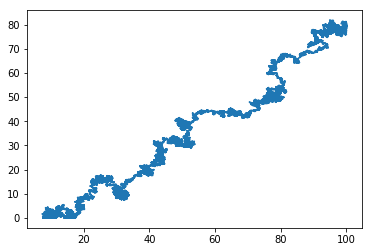

In [14]:
plt.plot(brake_data['life_expectancy_now'], brake_data['life_expectancy_then'])

In [37]:
import sys

In [38]:
!{sys.executable} -m pip install xgboost==0.81

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 16.6 MB 4.4 MB/s eta 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.0.1
    Uninstalling xgboost-1.0.1:
      Successfully uninstalled xgboost-1.0.1


In [34]:
import xgboost as xgb

In [16]:
import xgboost

In [17]:
xgboost.__version__

'0.81'

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [49]:
X_train, X_test, y_train, y_test = train_test_split(brake_data.iloc[:,:-1], brake_data.iloc[:,-1])

In [50]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

In [51]:
model = xgb.train({}, dtrain, 20)
#bst.save_model('./model.bst')

[02:15:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[02:15:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[02:15:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[02:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[02:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[02:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[02:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[02:15:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[02:15:48] 

In [52]:
y_test_aux = model.predict(dtest)

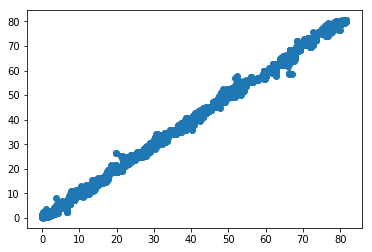

In [53]:
plt.scatter(y_test, y_test_aux)

In [55]:
pickle.dump(model, open('model_v3.pkl', 'wb'))

In [54]:
print('MAE: ', mean_squared_error(y_pred=y_test_aux, y_true=y_test))

MAE:  0.6906185844943658


In [20]:
xgbregressor = xgb.XGBRegressor()

xgbregressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
y_pred = xgbregressor.predict(X_test)

In [22]:
print('MSE: ', mean_squared_error(y_true=y_test, y_pred=y_pred))
print('MAE: ', mean_absolute_error(y_true=y_test, y_pred=y_pred))

MSE:  3.6287804188935464
MAE:  1.3950817542822185


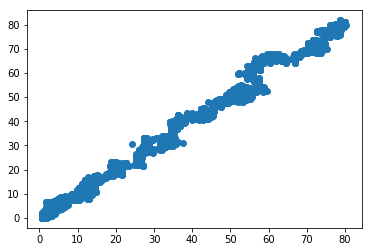

In [23]:
plt.scatter(y_pred, y_test)

In [24]:
import pickle

In [25]:
file_name = 'model.pkl'
pickle.dump(xgbregressor, open(file_name, "wb"))

Computations to make up the model. (Scrap all this later)

In [61]:
Y = np.array([1.0/600, 1.0/2000, 1.0/100])
X = np.array([
        [np.mean(np.array(dec_contribs)**2), np.mean(np.array(time_contribs)**0.5), np.mean(np.array(weight_contribs))],
        [np.min(np.array(dec_contribs)**2), np.max(np.array(time_contribs)**0.5), np.min(np.array(weight_contribs))],
        [np.max(np.array(dec_contribs)**2), np.min(np.array(time_contribs)**0.5), np.max(np.array(weight_contribs))]
    ])
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T), Y)
print(w)

[ 2.41797237e-04  1.64064786e-04 -2.57633089e-07]


In [43]:
np.mean(np.array(dec_contribs)**2)

7.137458337836701

In [46]:
np.min(np.array(dec_contribs)**2)

0.5727936590795073

In [47]:
np.max(np.array(dec_contribs)**2)

44.25376260319435

In [44]:
np.mean(np.array(time_contribs)**0.5)

8.489988768540968

In [48]:
np.min(np.array(time_contribs)**0.5)

6.623050323074155

In [49]:
np.max(np.array(time_contribs)**0.5)

10.092273438696369

In [45]:
np.mean(np.array(weight_contribs))

5636.151930708608

In [50]:
np.min(np.array(weight_contribs))

5023.759221337827

In [51]:
np.max(np.array(weight_contribs))

6936.4027912251695

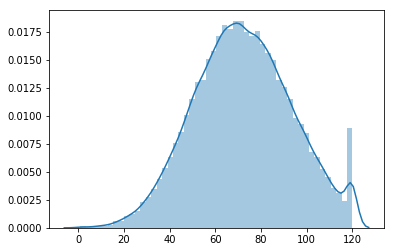

In [190]:
sns.distplot([time_events])

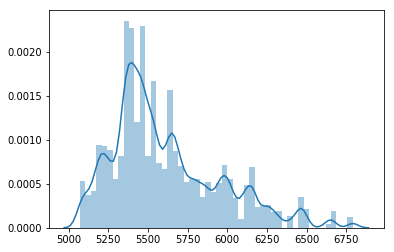

In [192]:
sns.distplot(weigth_events)

In [209]:
np.array([1/i for i in range(1,20)])/(sum([1/i for i in range(1,20)]))

array([0.28186961, 0.14093481, 0.09395654, 0.0704674 , 0.05637392,
       0.04697827, 0.04026709, 0.0352337 , 0.03131885, 0.02818696,
       0.02562451, 0.02348913, 0.02168228, 0.02013354, 0.01879131,
       0.01761685, 0.01658057, 0.01565942, 0.01483524])

In [208]:
np.array([1/(3*i) for i in range(1,20)])/(sum([1/(3*i) for i in range(1,20)]))

array([0.28186961, 0.14093481, 0.09395654, 0.0704674 , 0.05637392,
       0.04697827, 0.04026709, 0.0352337 , 0.03131885, 0.02818696,
       0.02562451, 0.02348913, 0.02168228, 0.02013354, 0.01879131,
       0.01761685, 0.01658057, 0.01565942, 0.01483524])